# Introduction

Three groups: microsatellite instability high (MSI-H), microsatellite instability low (MSI-L) and microsatellite stable (MSS).

Two sets of measurements: 7_marker, 5_marker. The original report consider one sample as MSI if both indicate positive.

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# mpl.rcParams['figure.dpi'] = 600

In [2]:
import sys
sys.path.append("..")
import sensei

In [3]:
from tcga_dicts import *

In [4]:
df = pd.read_excel("41591_2016_BFnm4191_MOESM27_ESM.xlsx", index=1)
df

,Sample Name,Average difference in microsatellite alleles relative to paired normal,Number Unstable Loci,Number Loci Called,Proportion Unstable Loci,Stability at chr8:7679723-7679741,MOSAIC classification,Tumor Type,MSI-PCR Result,In Training Set?
0,TCGA-GV-A6ZA,-0.000393,510,144859,0.003521,stable,MSS,BLCA,NaN,no
1,TCGA-H4-A2HO,0.001674,1203,244912,0.004912,stable,MSS,BLCA,NaN,no
2,TCGA-H4-A2HQ,0.000091,915,230733,0.003966,stable,MSS,BLCA,NaN,no
3,TCGA-HQ-A2OE,0.000061,526,165003,0.003188,stable,MSS,BLCA,NaN,no
4,TCGA-HQ-A2OF,0.000605,407,128967,0.003156,stable,MSS,BLCA,NaN,no
...,...,...,...,...,...,...,...,...,...,...
5925,TCGA-QS-A8F1,-0.000477,1316,226304,0.005815,stable,MSS,UCEC,ND,no
5926,TCGA-SJ-A6ZI,0.008849,3363,298901,0.011251,unstable,MSI-H,UCEC,ND,no
5927,TCGA-SJ-A6ZJ,0.002213,1610,239070,0.006734,stable,MSS,UCEC,ND,no
5928,TCGA-SL-A6J9,-0.000376,1023,194265,0.005266,stable,MSS,UCEC,ND,no


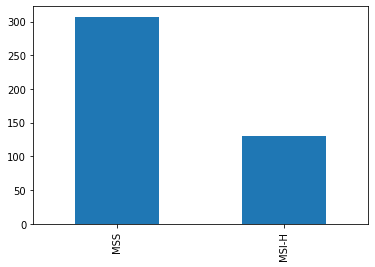

In [5]:
df[df['Tumor Type'] == 'UCEC']['MOSAIC classification'].value_counts().plot(kind="bar")

In [6]:
f = lambda x: x[0:3]
msi_mask = (df['MOSAIC classification'] == 'MSI-H') & (df['Tumor Type'] == 'UCEC')
mss_mask = (df['MOSAIC classification'] == 'MSS') & (df['Tumor Type'] == 'UCEC')

msi_patient_id = df['Sample Name'][msi_mask].to_frame()
mss_patient_id = df['Sample Name'][mss_mask].to_frame()

msi_patient_id['microsatellite'] = 'MSI-H'
mss_patient_id['microsatellite'] = 'MSS'

microsatellite_label_df = msi_patient_id.append(mss_patient_id)

In [7]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data["PatientID"] = data["SampleID"].apply(lambda x: '-'.join(x.split('-')[0:3]))

In [8]:
merged = data.merge(microsatellite_label_df, left_on="PatientID", right_on='Sample Name')

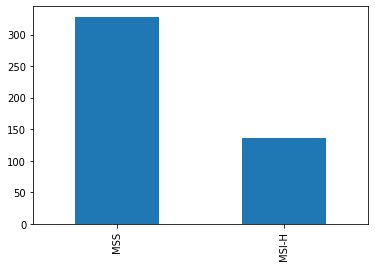

In [9]:
merged.microsatellite.value_counts().plot(kind="bar")

In [10]:
cell_types = ['B.cells.naive', 'B.cells.memory', 'Plasma.cells', 'T.cells.CD8',
       'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory..Tregs.', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils']

#merged['Leukocytes.all'] = merged[cell_types].sum(1)

merged['T.cells.all'] = merged[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

merged['B.cells.all'] = merged[['B.cells.naive', 'B.cells.memory', 'Plasma.cells']].sum(1)

merged['Nk.cells.all'] = merged[['NK.cells.resting', 'NK.cells.activated']].sum(1)

merged['Macrophages.all'] = merged[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

merged['Dendritic.cells.all'] = merged[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

merged['Mast.cells.all'] = merged[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all']

merged

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,RMSE,PatientID,Sample Name,microsatellite,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,TCGA-EO-A22Y-01A-11R-A180-07,UCEC,0.000000,0.080634,0.008700,0.066424,0.0,0.120280,0.0,0.064272,...,1.092848,TCGA-EO-A22Y,TCGA-EO-A22Y,MSS,0.278390,0.089334,0.094092,0.528625,0.003063,0.006495
1,TCGA-BK-A56F-01A-32R-A27V-07,UCEC,0.000000,0.053266,0.056248,0.114693,0.0,0.189724,0.0,0.052596,...,1.012650,TCGA-BK-A56F,TCGA-BK-A56F,MSS,0.408309,0.109514,0.083964,0.345620,0.005786,0.017160
2,TCGA-PG-A5BC-01A-12R-A27V-07,UCEC,0.106488,0.019595,0.076636,0.122491,0.0,0.203831,0.0,0.100763,...,0.994089,TCGA-PG-A5BC,TCGA-PG-A5BC,MSS,0.435877,0.202719,0.072082,0.198086,0.058367,0.019687
3,TCGA-EY-A54A-01A-11R-A27V-07,UCEC,0.017354,0.000000,0.038209,0.042937,0.0,0.307244,0.0,0.079982,...,1.052465,TCGA-EY-A54A,TCGA-EY-A54A,MSS,0.430163,0.055563,0.029814,0.393554,0.020703,0.020579
4,TCGA-AJ-A3NC-01A-11R-A22K-07,UCEC,0.067656,0.012511,0.028619,0.053432,0.0,0.137966,0.0,0.098371,...,1.047294,TCGA-AJ-A3NC,TCGA-AJ-A3NC,MSS,0.354307,0.108786,0.147521,0.224501,0.015424,0.031611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,TCGA-4E-A92E-01A-11R-A37O-07,UCEC,0.046195,0.000000,0.030850,0.205641,0.0,0.063863,0.0,0.178285,...,1.034397,TCGA-4E-A92E,TCGA-4E-A92E,MSS,0.473637,0.077044,0.039144,0.363599,0.000000,0.029639
460,TCGA-2E-A9G8-01A-11R-A40A-07,UCEC,0.000000,0.035739,0.111000,0.168203,0.0,0.000000,0.0,0.197915,...,1.002022,TCGA-2E-A9G8,TCGA-2E-A9G8,MSS,0.404185,0.146739,0.093531,0.198321,0.010964,0.111427
461,TCGA-A5-AB3J-01A-11R-A40A-07,UCEC,0.229559,0.000000,0.143764,0.065165,0.0,0.178858,0.0,0.055698,...,0.915280,TCGA-A5-AB3J,TCGA-A5-AB3J,MSS,0.317685,0.373323,0.070916,0.195315,0.000960,0.038476
462,TCGA-JU-AAVI-01A-11R-A40A-07,UCEC,0.021791,0.000000,0.054091,0.312219,0.0,0.000000,0.0,0.260242,...,1.089860,TCGA-JU-AAVI,TCGA-JU-AAVI,MSS,0.579214,0.075882,0.125063,0.214592,0.004145,0.001104


In [11]:
mss = merged[merged.microsatellite == 'MSS'][augmented_cell_types]
msi = merged[merged.microsatellite == 'MSI-H'][augmented_cell_types]

In [12]:
mss

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,0.000000,0.080634,0.008700,0.066424,0.0,0.120280,0.0,0.064272,0.027414,0.0,...,0.006495,0.000000,0.000000,0.000000,0.278390,0.089334,0.094092,0.528625,0.003063,0.006495
1,0.000000,0.053266,0.056248,0.114693,0.0,0.189724,0.0,0.052596,0.051296,0.0,...,0.017160,0.000000,0.000000,0.009495,0.408309,0.109514,0.083964,0.345620,0.005786,0.017160
2,0.106488,0.019595,0.076636,0.122491,0.0,0.203831,0.0,0.100763,0.008792,0.0,...,0.019687,0.000000,0.000000,0.000000,0.435877,0.202719,0.072082,0.198086,0.058367,0.019687
3,0.017354,0.000000,0.038209,0.042937,0.0,0.307244,0.0,0.079982,0.000000,0.0,...,0.000000,0.020579,0.018649,0.000000,0.430163,0.055563,0.029814,0.393554,0.020703,0.020579
4,0.067656,0.012511,0.028619,0.053432,0.0,0.137966,0.0,0.098371,0.064538,0.0,...,0.031611,0.000000,0.000000,0.117851,0.354307,0.108786,0.147521,0.224501,0.015424,0.031611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.018168,0.015065,0.277106,0.096912,0.0,0.042755,0.0,0.028701,0.001256,0.0,...,0.190131,0.000000,0.000000,0.000000,0.169624,0.310339,0.101802,0.190892,0.000160,0.190131
459,0.046195,0.000000,0.030850,0.205641,0.0,0.063863,0.0,0.178285,0.025848,0.0,...,0.000000,0.029639,0.000000,0.004780,0.473637,0.077044,0.039144,0.363599,0.000000,0.029639
460,0.000000,0.035739,0.111000,0.168203,0.0,0.000000,0.0,0.197915,0.038067,0.0,...,0.111427,0.000000,0.019942,0.000000,0.404185,0.146739,0.093531,0.198321,0.010964,0.111427
461,0.229559,0.000000,0.143764,0.065165,0.0,0.178858,0.0,0.055698,0.017964,0.0,...,0.038476,0.000000,0.000000,0.000000,0.317685,0.373323,0.070916,0.195315,0.000960,0.038476


# Results

## MSS

In [13]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_mss = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = mss.shape[0];

# Mean
res_mss['mean'] = mss.mean(axis=0)

res_mss['sd'] = mss.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_mss['sd'] / np.sqrt(n)
res_mss['mean lower'] = (res_mss['mean'] - err).apply(sanitize)
res_mss['mean upper'] = (res_mss['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_mss['sd lower'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_mss['sd upper'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_mss

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.042185,0.035817,0.048553,0.058621,0.054452,0.063487
B.cells.memory,0.031086,0.026197,0.035975,0.045004,0.041804,0.048740
Plasma.cells,0.061775,0.055269,0.068281,0.059895,0.055636,0.064867
T.cells.CD8,0.123512,0.115039,0.131985,0.078006,0.072458,0.084480
T.cells.CD4.naive,0.004173,0.002188,0.006158,0.018272,0.016973,0.019789
T.cells.CD4.memory.resting,0.080897,0.072586,0.089209,0.076515,0.071073,0.082866
T.cells.CD4.memory.activated,0.002093,0.001071,0.003116,0.009413,0.008744,0.010194
T.cells.follicular.helper,0.097360,0.090579,0.104141,0.062431,0.057991,0.067613
T.cells.regulatory..Tregs.,0.054648,0.049468,0.059828,0.047689,0.044297,0.051647
T.cells.gamma.delta,0.003530,0.001842,0.005217,0.015535,0.014430,0.016825


## MSI

In [14]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_msi = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = msi.shape[0];

# Mean
res_msi['mean'] = msi.mean(axis=0)

res_msi['sd'] = msi.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_msi['sd'] / np.sqrt(n)
res_msi['mean lower'] = (res_msi['mean'] - err).apply(sanitize)
res_msi['mean upper'] = (res_msi['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_msi['sd lower'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_msi['sd upper'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_msi

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.040813,0.033391,0.048235,0.043766,0.039110,0.049690
B.cells.memory,0.020004,0.012366,0.027642,0.045039,0.040248,0.051136
Plasma.cells,0.057544,0.048457,0.066630,0.053581,0.047881,0.060833
T.cells.CD8,0.180827,0.165011,0.196644,0.093266,0.083344,0.105891
T.cells.CD4.naive,0.001976,0.000020,0.003933,0.011537,0.010310,0.013099
T.cells.CD4.memory.resting,0.054191,0.044688,0.063693,0.056034,0.050073,0.063619
T.cells.CD4.memory.activated,0.004503,0.002289,0.006718,0.013061,0.011671,0.014829
T.cells.follicular.helper,0.133385,0.122402,0.144369,0.064768,0.057878,0.073535
T.cells.regulatory..Tregs.,0.060020,0.051831,0.068210,0.048291,0.043154,0.054828
T.cells.gamma.delta,0.001554,0.000434,0.002673,0.006600,0.005898,0.007493


## Figures

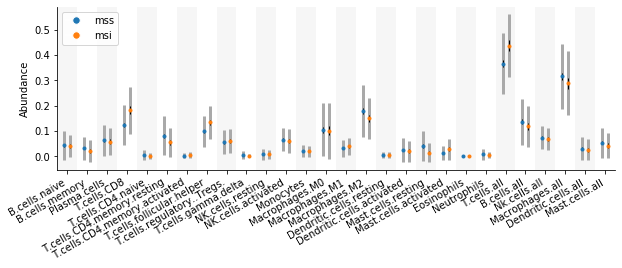

In [15]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 'mss': -0.15,
 'msi': 0.15}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {'mss': colors[0],
 'msi': colors[1]}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

n = mss.shape[0];
mean = mss.mean(axis=0)
sd = mss.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['mss'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['mss'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['mss'], ecolor = 'black', elinewidth=1.0)

n = msi.shape[0];
mean = msi.mean(axis=0)
sd = msi.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['msi'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['msi'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['msi'], ecolor = 'black', elinewidth=1.0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')

In [16]:
msi

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
7,0.000000,0.152152,0.060030,0.044565,0.0,0.028825,0.000000,0.125960,0.012963,0.000000,...,0.000000,0.063961,0.0,0.000000,0.212313,0.212182,0.081579,0.163893,0.234254,0.063961
11,0.000000,0.002401,0.083875,0.126984,0.0,0.009166,0.011565,0.122750,0.084428,0.043797,...,0.004881,0.000000,0.0,0.000000,0.398690,0.086276,0.133324,0.362548,0.014280,0.004881
16,0.098635,0.000000,0.025687,0.261011,0.0,0.013107,0.000857,0.136509,0.014139,0.000000,...,0.000000,0.080405,0.0,0.009571,0.425624,0.124322,0.045689,0.289234,0.006970,0.080405
25,0.000000,0.000000,0.074770,0.080107,0.0,0.010130,0.000000,0.114782,0.045862,0.000000,...,0.000000,0.068969,0.0,0.003889,0.250881,0.074770,0.071715,0.379089,0.109655,0.068969
26,0.062358,0.000000,0.036579,0.107230,0.0,0.036868,0.000000,0.087905,0.000000,0.000000,...,0.019912,0.161210,0.0,0.018891,0.232003,0.098937,0.091752,0.310395,0.000000,0.181122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,0.090975,0.000000,0.162220,0.189161,0.0,0.121679,0.000000,0.170998,0.033636,0.000000,...,0.012040,0.000000,0.0,0.000000,0.515474,0.253195,0.034574,0.167919,0.001511,0.012040
456,0.073302,0.000000,0.052458,0.340889,0.0,0.000000,0.001218,0.156837,0.029933,0.000000,...,0.001848,0.000000,0.0,0.000000,0.528877,0.125760,0.047590,0.292292,0.000000,0.001848
457,0.113861,0.000000,0.069176,0.115605,0.0,0.110702,0.000000,0.149902,0.053295,0.000000,...,0.000000,0.000000,0.0,0.000000,0.429503,0.183037,0.035658,0.343985,0.000000,0.000000
458,0.000000,0.005502,0.053221,0.228970,0.0,0.000000,0.000000,0.184519,0.106743,0.000000,...,0.032853,0.000000,0.0,0.003366,0.520232,0.058724,0.082852,0.265683,0.011442,0.032853


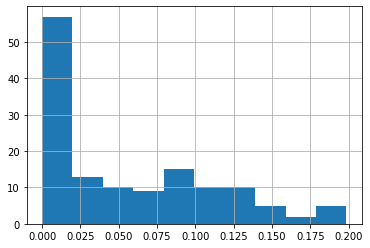

In [17]:
msi['T.cells.CD4.memory.resting'].hist()

In [18]:
scipy.stats.skew(msi)

array([ 1.16196963,  3.02683227,  2.1330877 ,  0.81652282,  6.51285803,
        0.68045916,  4.00361516,  0.39315129,  1.14304721,  4.6594394 ,
        2.93655831,  1.20895892,  1.65164431,  1.52740949,  1.33674457,
        0.86190523,  2.69171458,  3.06474279,  5.82073913,  1.97728747,
       11.09036613,  4.11494537, -0.05377647,  1.16046064,  1.24853379,
        0.33835066,  2.79605966,  2.64120852])

In [19]:
scipy.stats.skewtest(msi)

SkewtestResult(statistic=array([ 4.79900064,  8.58147766,  7.12486819,  3.64785226, 11.89033958,
        3.12936041,  9.77675455,  1.90393643,  4.74151823, 10.43223207,
        8.45342982,  4.93920986,  6.10470338,  5.80328081,  5.30313019,
        3.81216295,  8.08710264,  8.63420566, 11.39982591,  6.81756755,
       14.22497131,  9.89496374, -0.26842414,  4.79443842,  5.05456825,
        1.65108136,  8.24678195,  8.00779359]), pvalue=array([1.59459287e-06, 9.36620821e-18, 1.04180336e-12, 2.64441613e-04,
       1.32865281e-32, 1.75187285e-03, 1.41680860e-22, 5.69184643e-02,
       2.12122567e-06, 1.76688181e-25, 2.82867998e-17, 7.84397590e-07,
       1.02991772e-09, 6.50297452e-09, 1.13833676e-07, 1.37756009e-04,
       6.11007725e-16, 5.91365250e-18, 4.18956033e-30, 9.25948713e-12,
       6.41306441e-46, 4.37769034e-23, 7.88372857e-01, 1.63131167e-06,
       4.31365491e-07, 9.87219626e-02, 1.62716929e-16, 1.16784699e-15]))

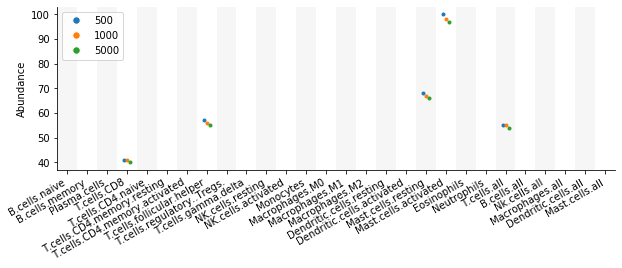

In [20]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 '500': -0.15,
 '1000': -0.0,
 '5000': 0.15}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {
 '500': colors[0],
 '1000': colors[1],
 '5000': colors[2]}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

mss_n = mss.shape[0];
mss_mean = mss.mean(axis=0)
mss_sd = mss.std(ddof=1, axis=0)
mss_err = scipy.stats.t.ppf(1 - a / 2, mss_n - 1) * mss_sd / np.sqrt(mss_n)

msi_n = msi.shape[0];
msi_mean = msi.mean(axis=0)
msi_sd = msi.std(ddof=1, axis=0)
msi_err = scipy.stats.t.ppf(1 - a / 2, msi_n - 1) * msi_sd / np.sqrt(msi_n)

x = [v + offset_map['500'] for v in x_map.values()]
y = [sensei.optimize.find_minimum_M(100, 500, [m0, m1], [s0, s1], design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
ax.errorbar(x, y, yerr=0, fmt='.', color = color_map['500'], ecolor = 'darkgray', elinewidth=3.0)

x = [v + offset_map['1000'] for v in x_map.values()]
y = [sensei.optimize.find_minimum_M(100, 1000, [m0, m1], [s0, s1], design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
ax.errorbar(x, y, yerr=0, fmt='.', color = color_map['1000'], ecolor = 'darkgray', elinewidth=3.0)

x = [v + offset_map['5000'] for v in x_map.values()]
y = [sensei.optimize.find_minimum_M(100, 5000, [m0, m1], [s0, s1], design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
ax.errorbar(x, y, yerr=0, fmt='.', color = color_map['5000'], ecolor = 'darkgray', elinewidth=3.0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')

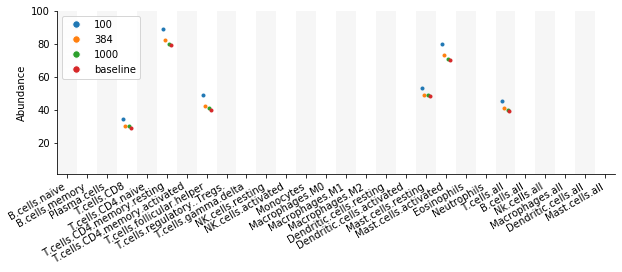

In [21]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 100: -0.2,
 384: -0.1,
 1000: 0.1,
 'baseline': 0.2}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {
 100: colors[0],
 384: colors[1],
 1000: colors[2],
 'baseline': colors[3]}

mem = {100: None,
      384: None,
      1000: None,
      'baseline': None}


fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

mss_n = mss.shape[0];
mss_mean = mss.mean(axis=0)
mss_sd = mss.std(ddof=1, axis=0)
mss_err = scipy.stats.t.ppf(1 - a / 2, mss_n - 1) * mss_sd / np.sqrt(mss_n)

msi_n = msi.shape[0];
msi_mean = msi.mean(axis=0)
msi_sd = msi.std(ddof=1, axis=0)
msi_err = scipy.stats.t.ppf(1 - a / 2, msi_n - 1) * msi_sd / np.sqrt(msi_n)

for cell_number in [100, 384, 1000]:
    x = [v + offset_map[cell_number] for v in x_map.values()]
    y = [sensei.optimize.find_minimum_M(10000, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
    ax.errorbar(x, y, yerr=0, fmt='.', color = color_map[cell_number], ecolor = 'darkgray', elinewidth=3.0)
    mem[cell_number] = y
    
x = [v + offset_map['baseline'] for v in x_map.values()]
y = [sensei.optimize.find_minimum_M(10000, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired-baseline') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
ax.errorbar(x, y, yerr=0, fmt='.', color = color_map['baseline'], ecolor = 'darkgray', elinewidth=3.0)
mem['baseline'] = y
effect = [m1 - m0 for m0, m1 in zip(mss_mean, msi_mean)]

import pickle as pkl
with open("msi-mss-ucec.pkl", 'wb') as f:
    pkl.dump(mem, f)
    
with open("msi-mss-ucec-effect.pkl", 'wb') as f:
    pkl.dump(effect, f)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim([1, 100])
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')